# imports

In [231]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [211]:
# 무조건 버전 0.12.2 이어야 함.
import statsmodels
statsmodels.__version__

'0.12.2'

In [212]:
# !pip install statsmodels-- 0.12.2

In [213]:
# !pip install -U finance-datareader

In [214]:
import talib
from pandas_datareader import data
import FinanceDataReader as fdr

# read

In [215]:
df = pd.read_csv('./kospi.csv')
# kospi  = fdr.DataReader('KS11', '1980') # 1980 ~ 오늘
# sp500  = fdr.DataReader('US500', '2019') # 2019 ~ 오늘
# nasdaq = fdr.DataReader('NDAQ', '2019') # 2019 ~ 오늘
# 코스피('KS11'), S&P 500('US500'), 나스닥('NDAQ')
# CD금리, 미 국채 ETF 필요

# ARIMA

In [216]:
df['STDEV'] = talib.STDDEV(df['Close'], timeperiod=20)

In [217]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,STDEV
4652,2021-11-08,2968.17993,2930.89990,2965.36011,2960.19995,559600.00000,2960.19995,31.11496
4653,2021-11-09,2987.28003,2949.16992,2958.14990,2962.45996,707800.00000,2962.45996,26.65775
4654,2021-11-10,2958.61011,2924.36011,2947.45996,2930.16992,567300.00000,2930.16992,28.18472
4655,2021-11-11,2925.18994,2903.71997,2911.40991,2924.91992,571900.00000,2924.91992,32.13244
4656,2021-11-12,2973.84009,2938.27002,2945.94995,2968.80005,665000.00000,2968.80005,32.09423


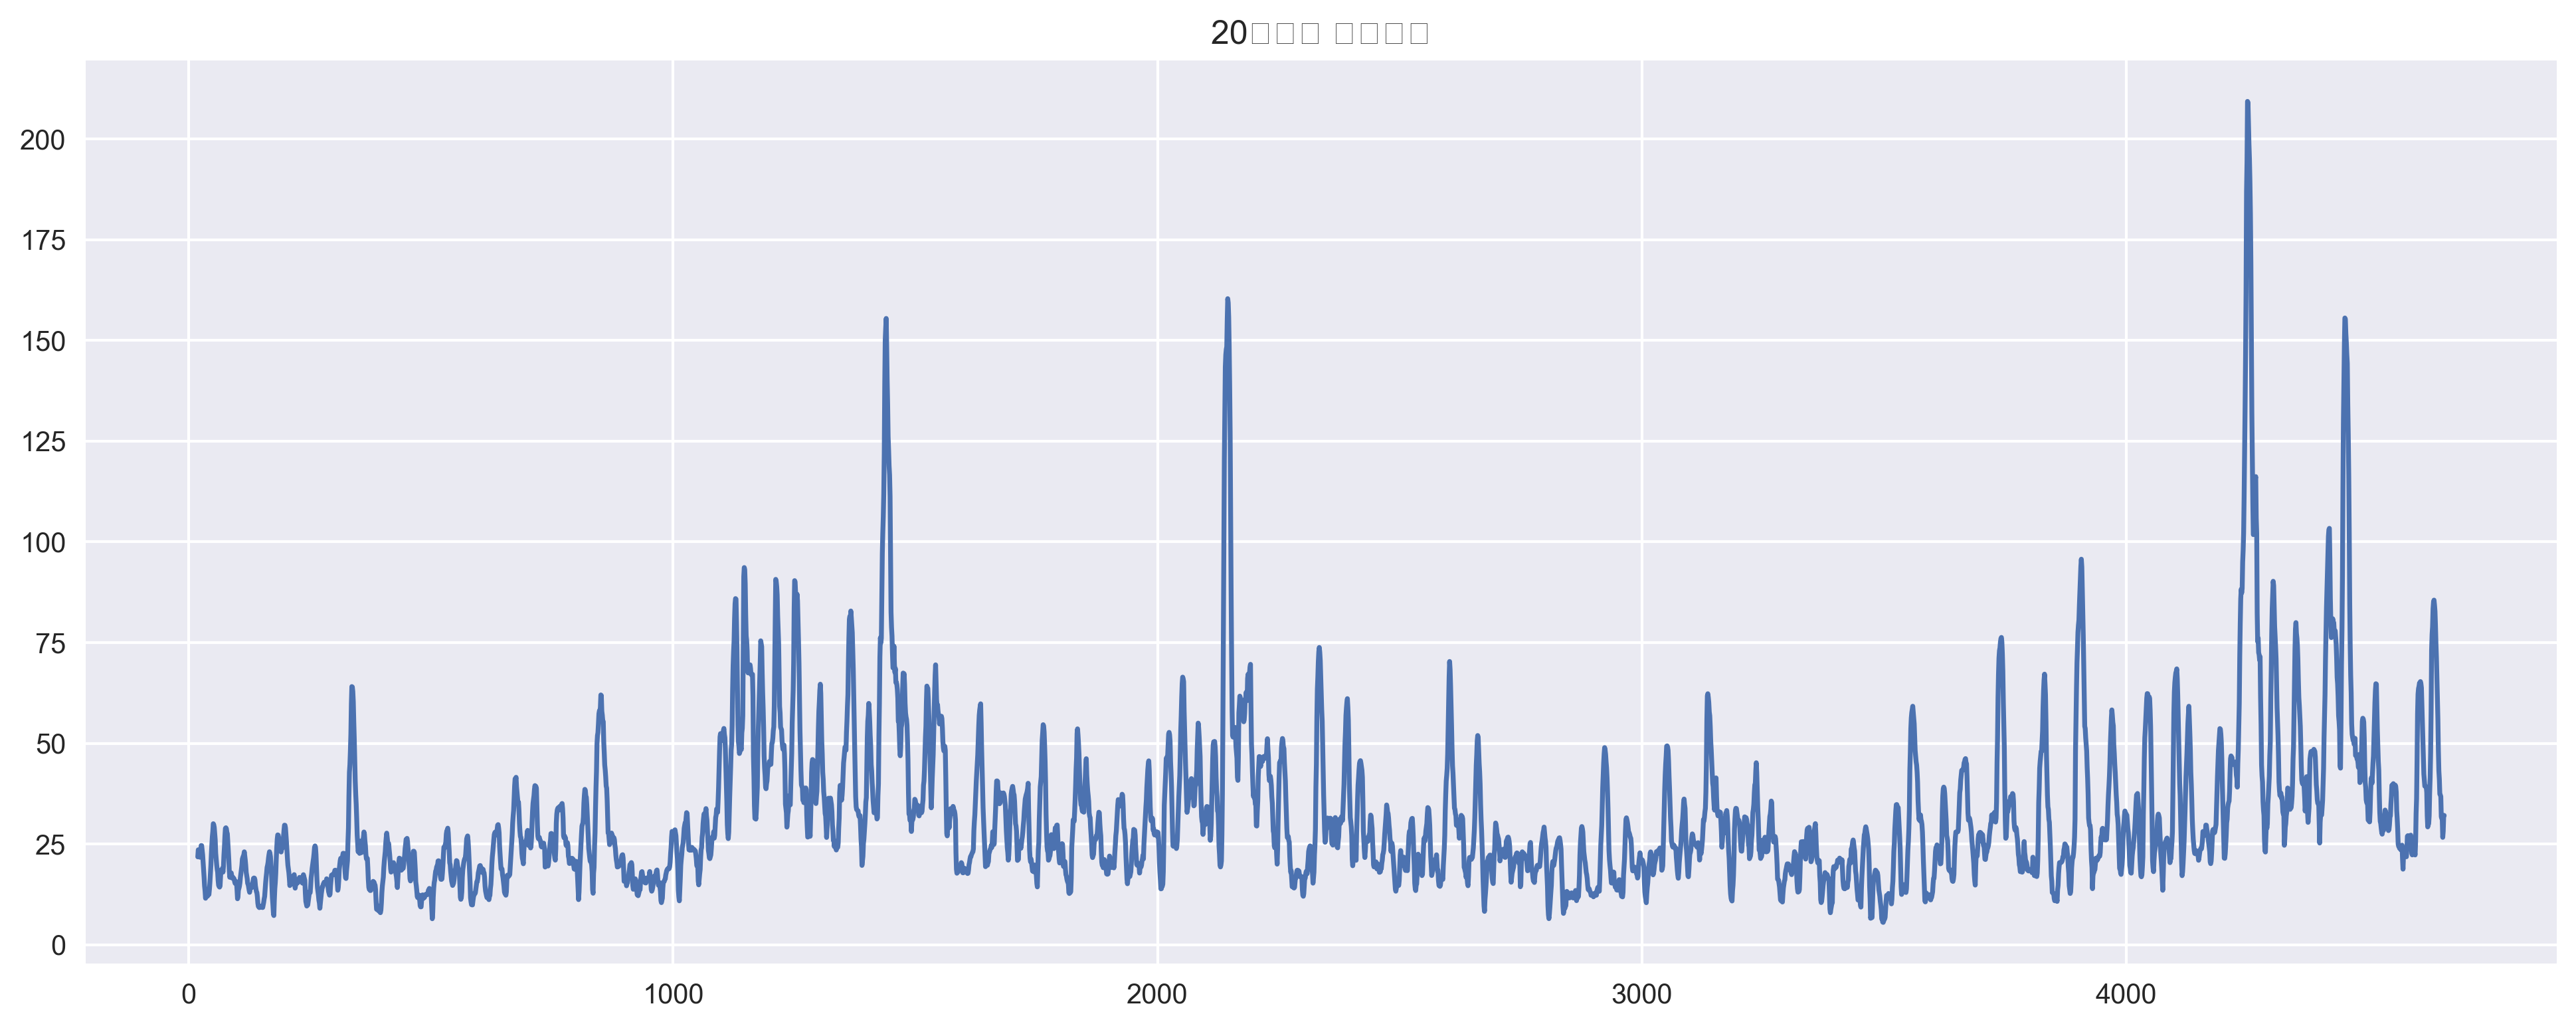

In [218]:
# 표준편차 그래프 보기
plt.figure(figsize=(16,6))
df['STDEV'].plot()
plt.title("20일짜리 표준편차")
plt.show()

In [219]:
# 변동폭이 일정하지 않으므로, STDEV를 로그 변환
df['STDEV'] = np.log(df['STDEV']) 

In [220]:
# nan 값 삭제
df = df.dropna()

In [221]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,STDEV
19,2003-01-29,602.17999,581.13000,601.25000,583.34998,562800.00000,583.34998,3.08308
20,2003-01-30,593.70001,586.03003,589.07001,591.85999,510700.00000,591.85999,3.16018
21,2003-02-03,602.84998,586.14001,591.88000,600.40997,425300.00000,600.40997,3.15189
22,2003-02-04,605.59003,596.78003,602.28998,603.78003,709200.00000,603.78003,3.09666
23,2003-02-05,606.70001,595.39001,598.34003,600.67999,755800.00000,600.67999,3.07985


In [222]:
close_df = df[['Date','STDEV']]
close_df = close_df.sort_values('Date')
close_df = close_df.set_index('Date')

In [223]:
train_df = close_df.loc['2003-09-29':'2020-09-28']  #2003-9-29 ~ 2020-9-28
test_df  = close_df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28

In [224]:
train_df.tail()

,STDEV
Date,
2020-09-22,3.47457
2020-09-23,3.52641
2020-09-24,3.71018
2020-09-25,3.82984
2020-09-28,3.85358


In [225]:
test_df.tail()

,STDEV
Date,
2021-09-17,3.46589
2021-09-23,3.37613
2021-09-24,3.39321
2021-09-27,3.40326
2021-09-28,3.46615


<AxesSubplot:xlabel='Date'>

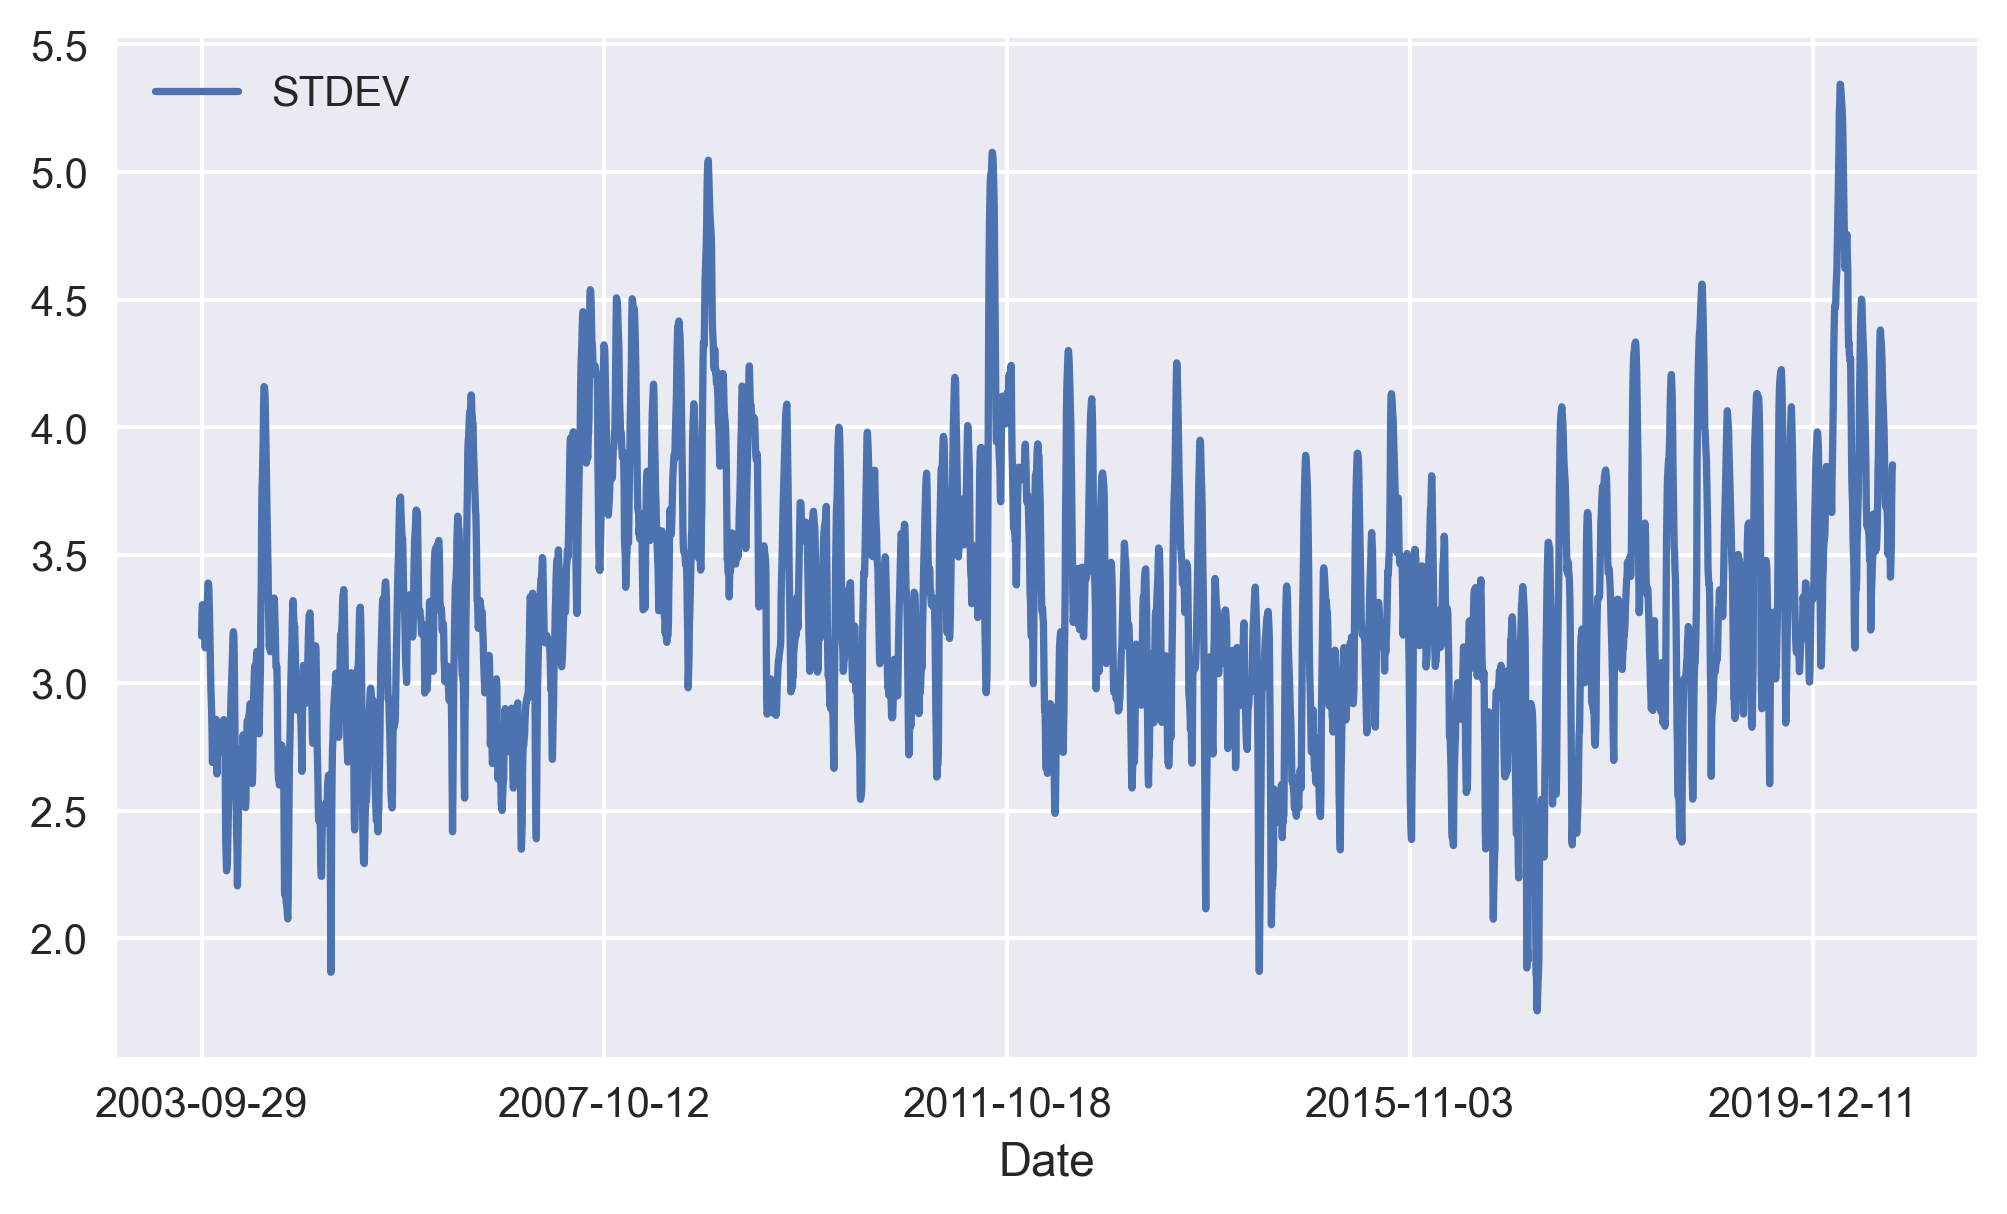

In [226]:
train_df.plot()

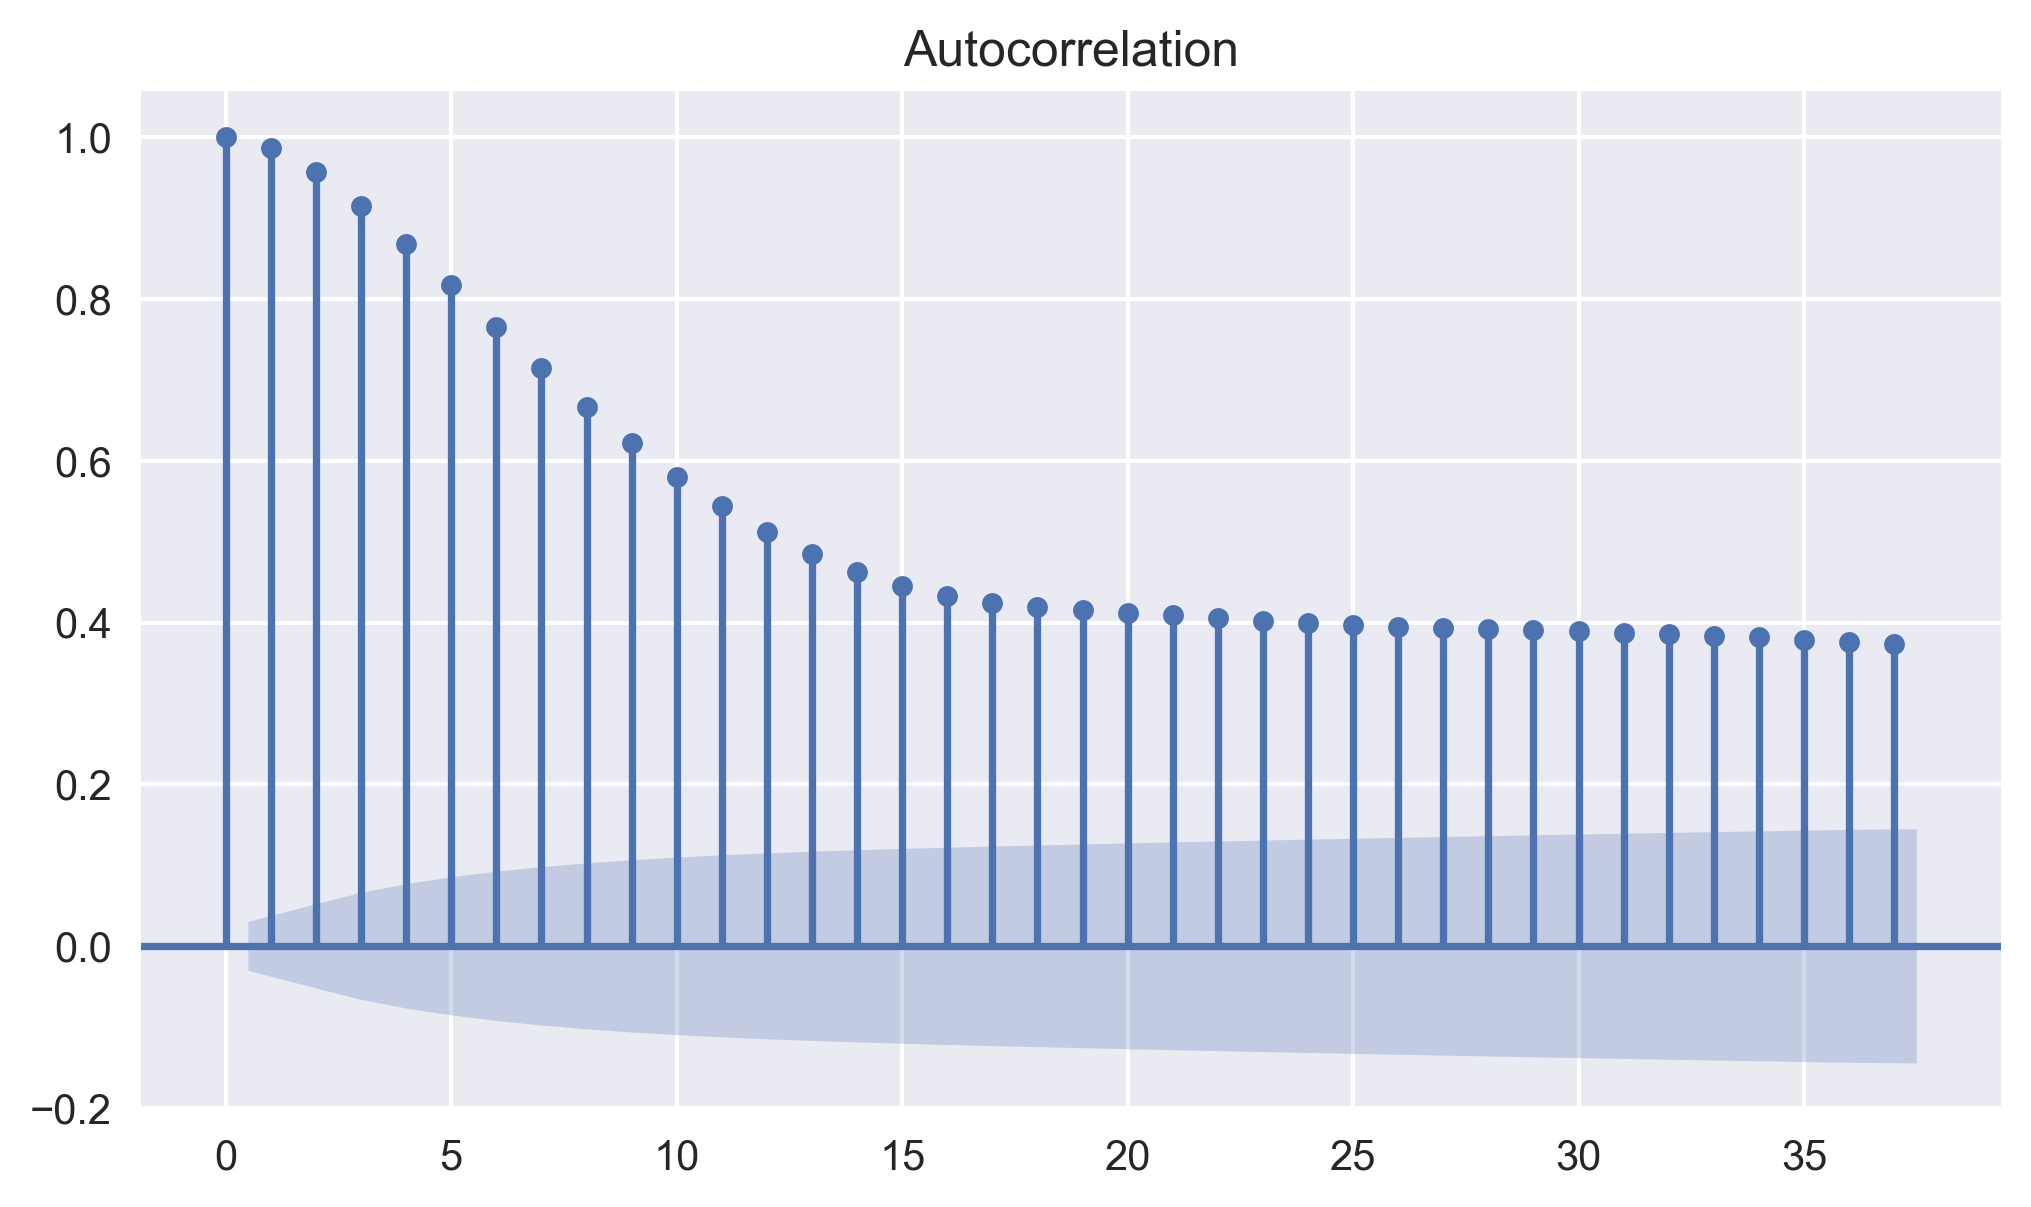

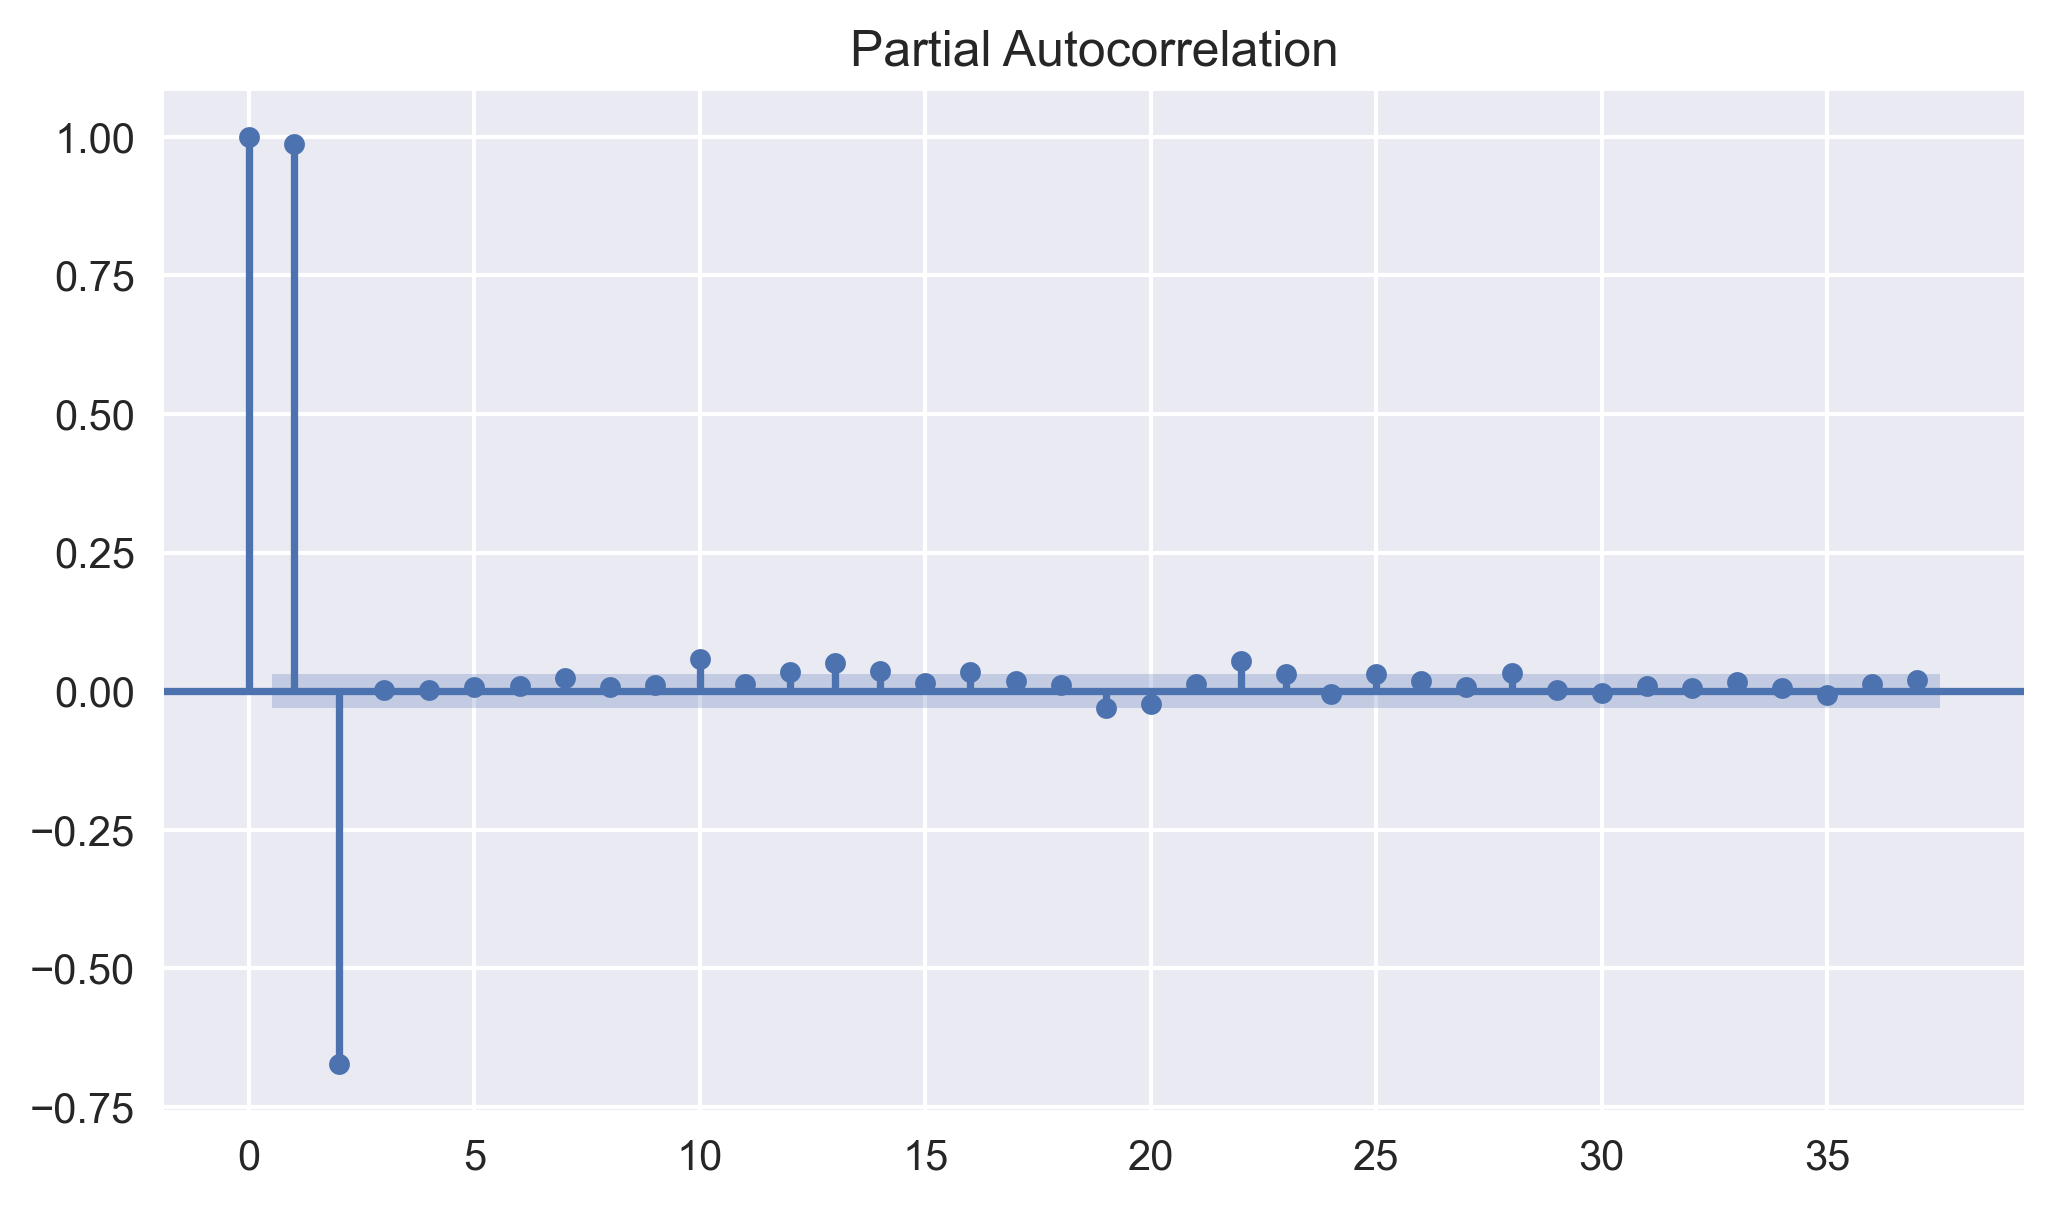

In [227]:
# AR특성: ACF는 천천히 감소, PACF는 급격히 감소
plot_acf(train_df)
plot_pacf(train_df)   
plt.show()

# 차분해서 정상성 확인

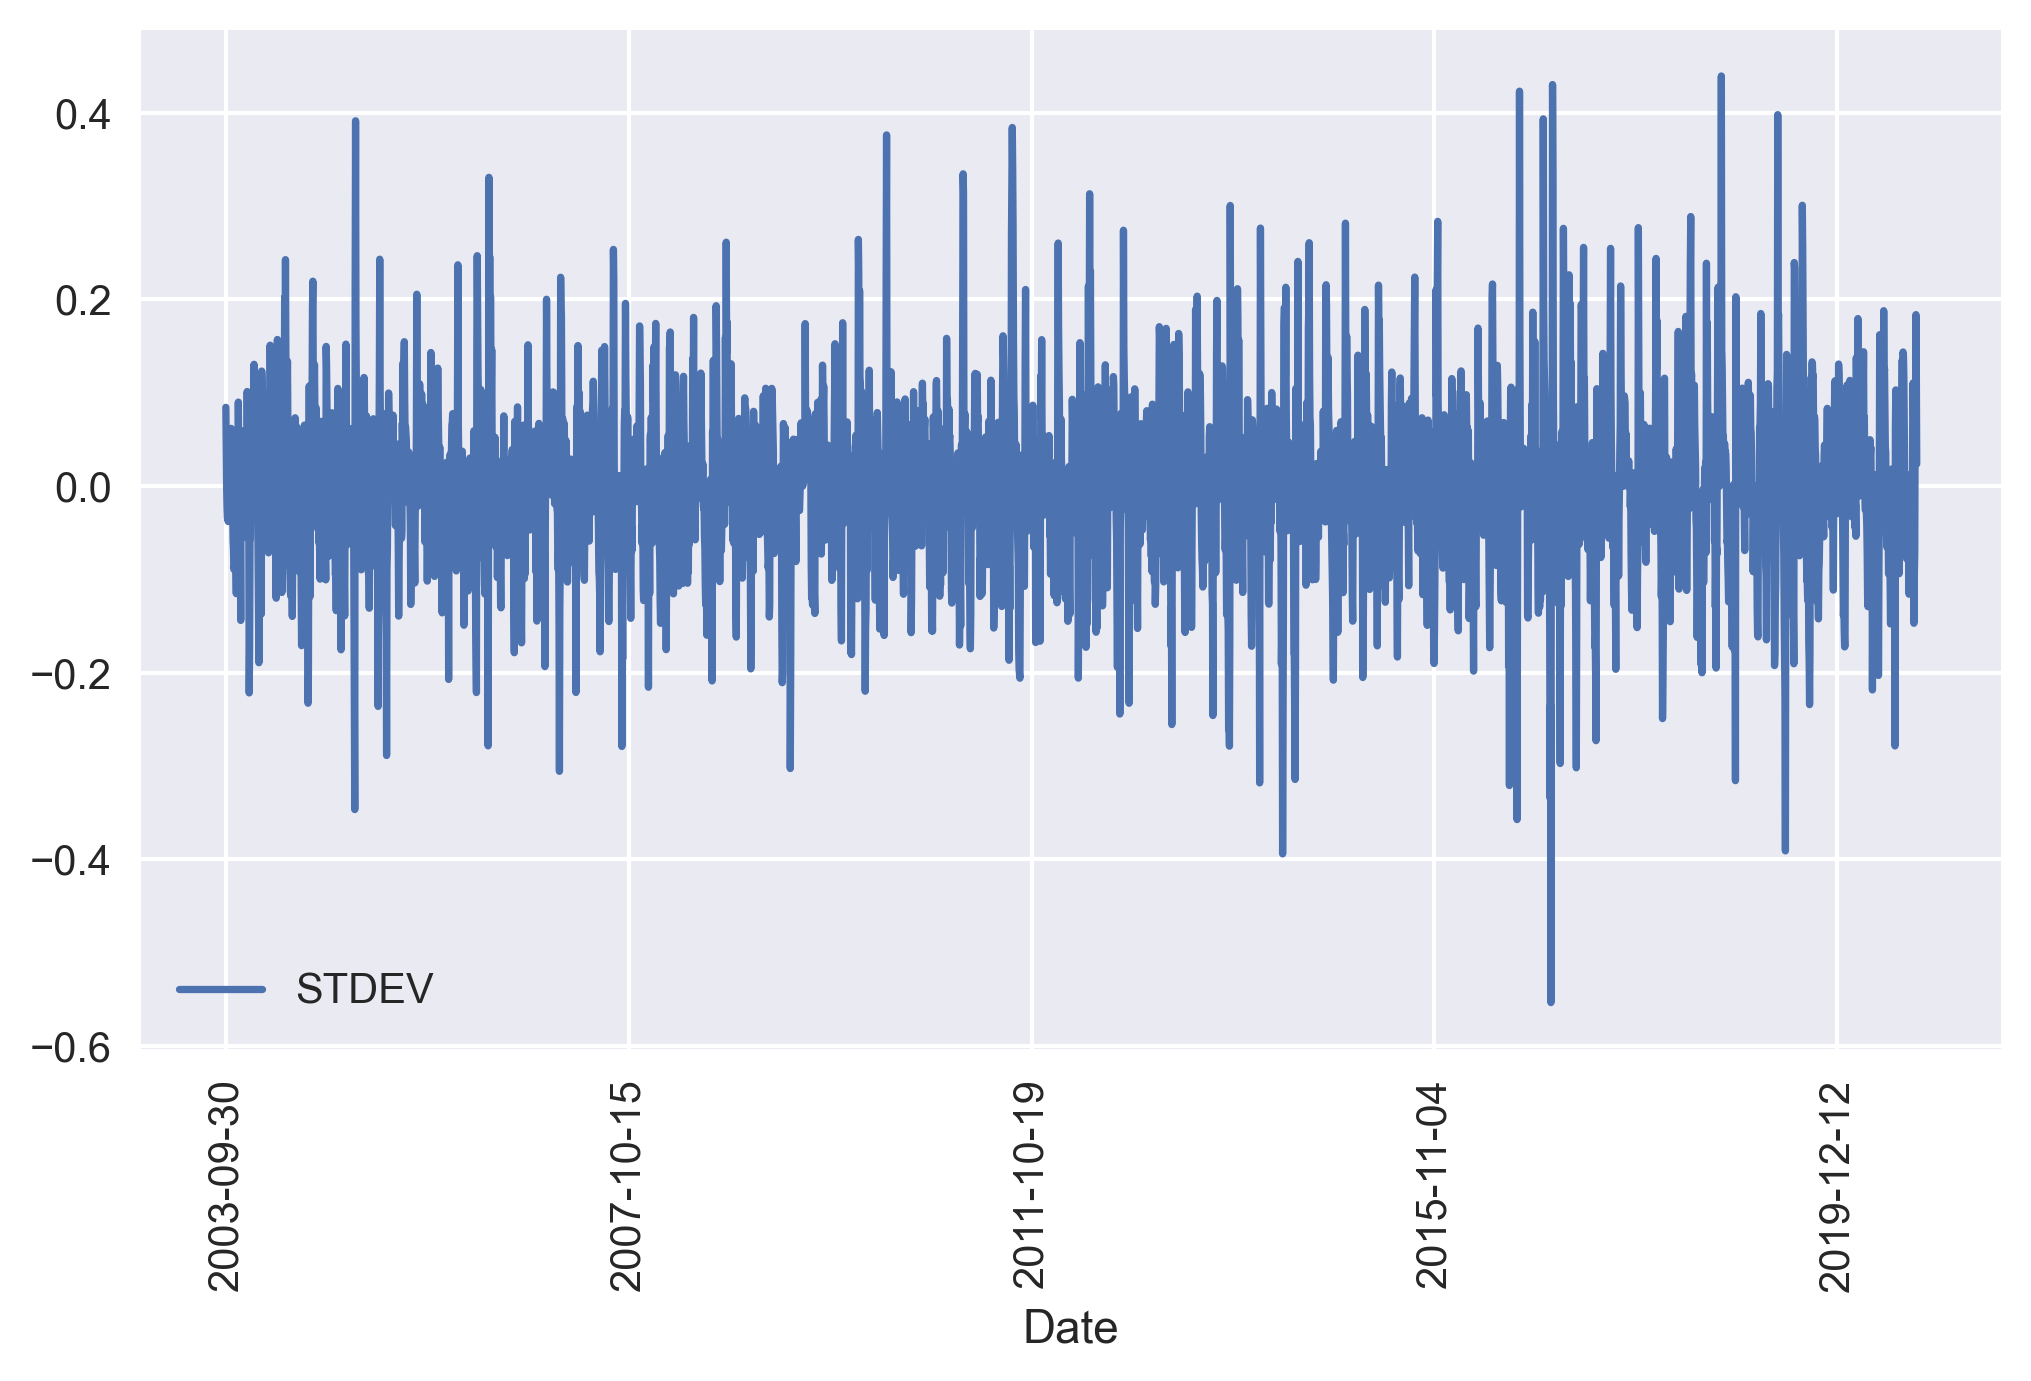

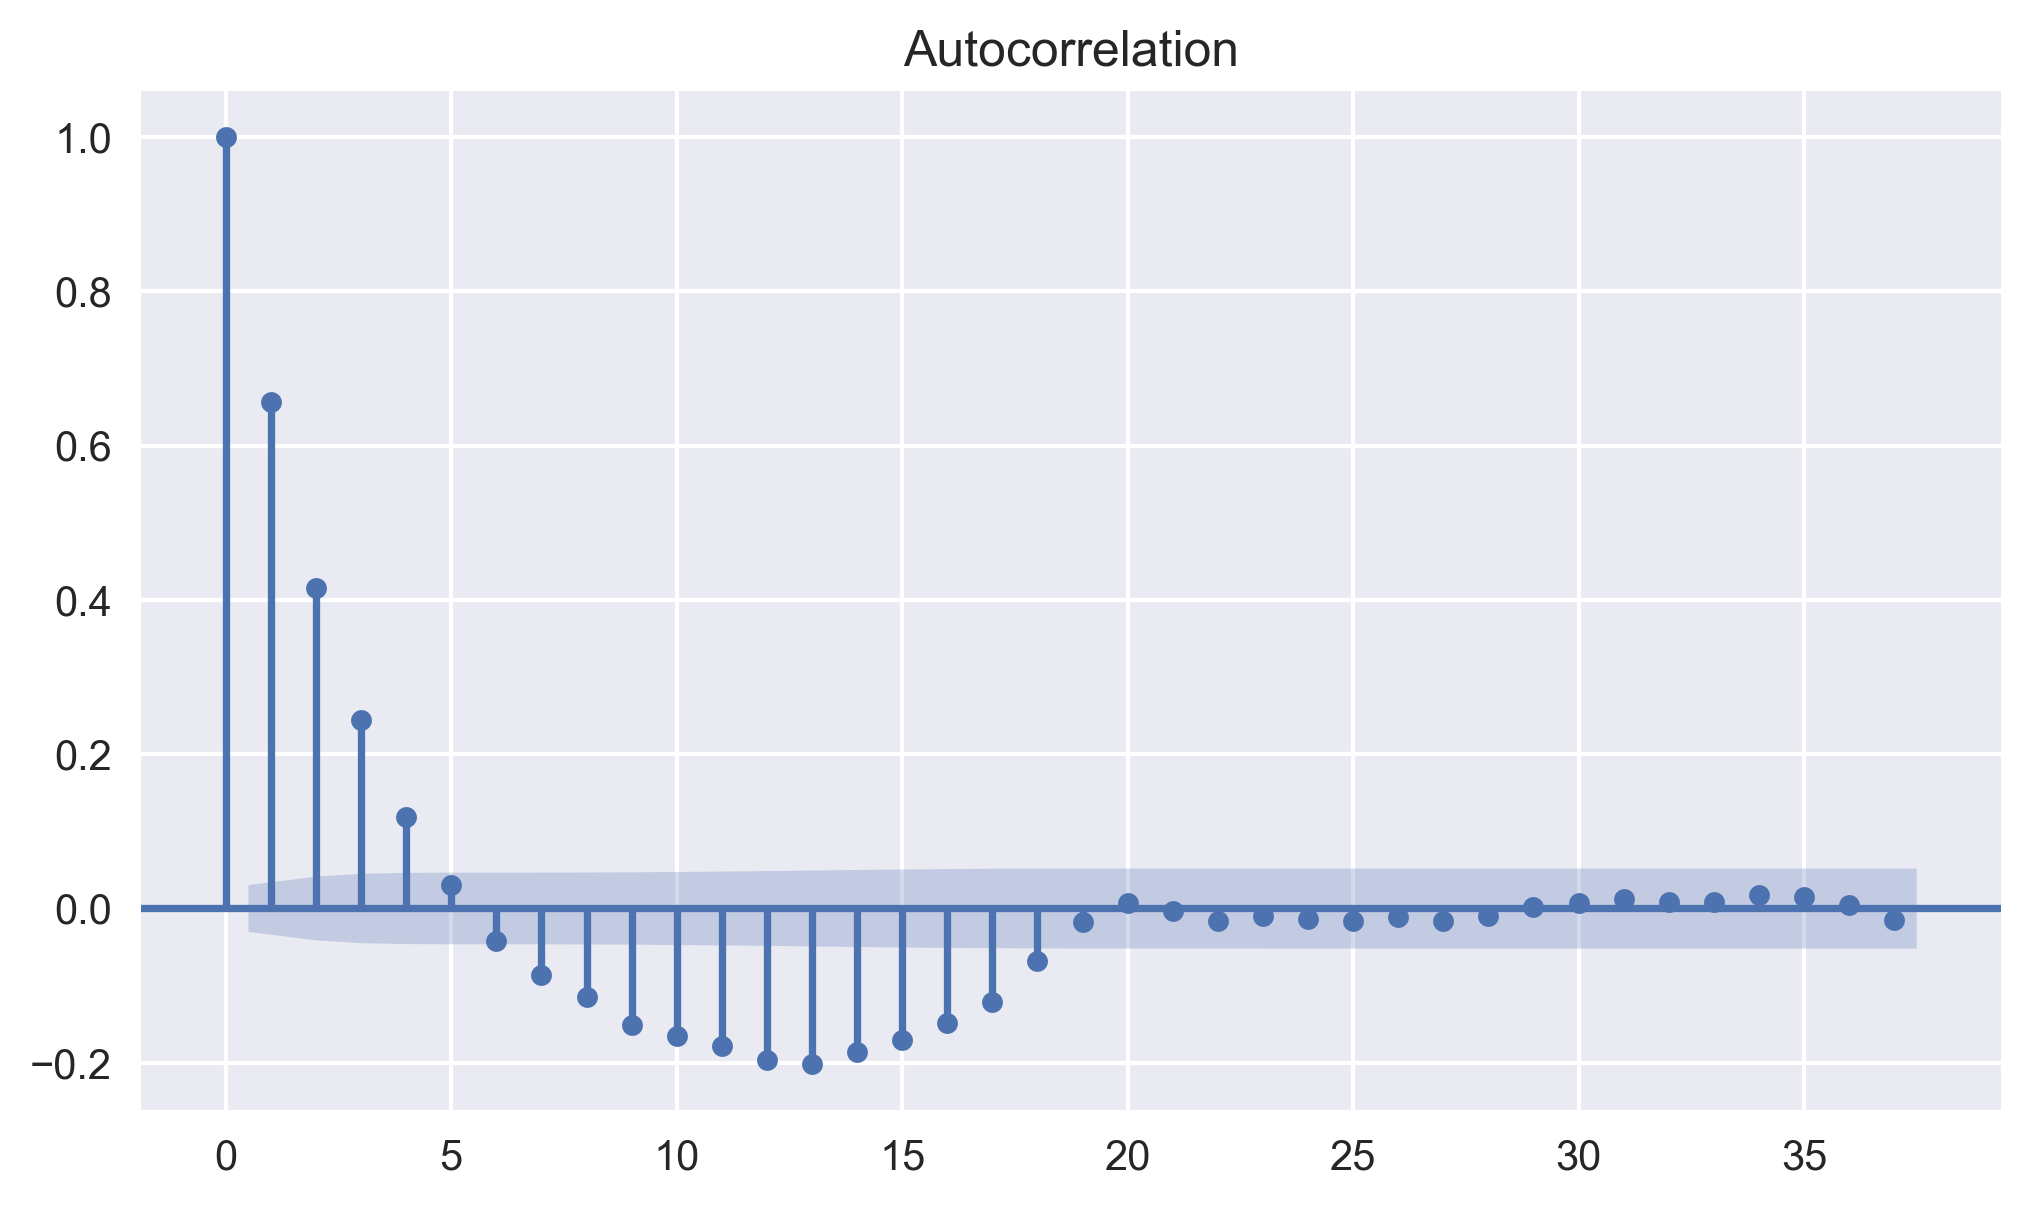

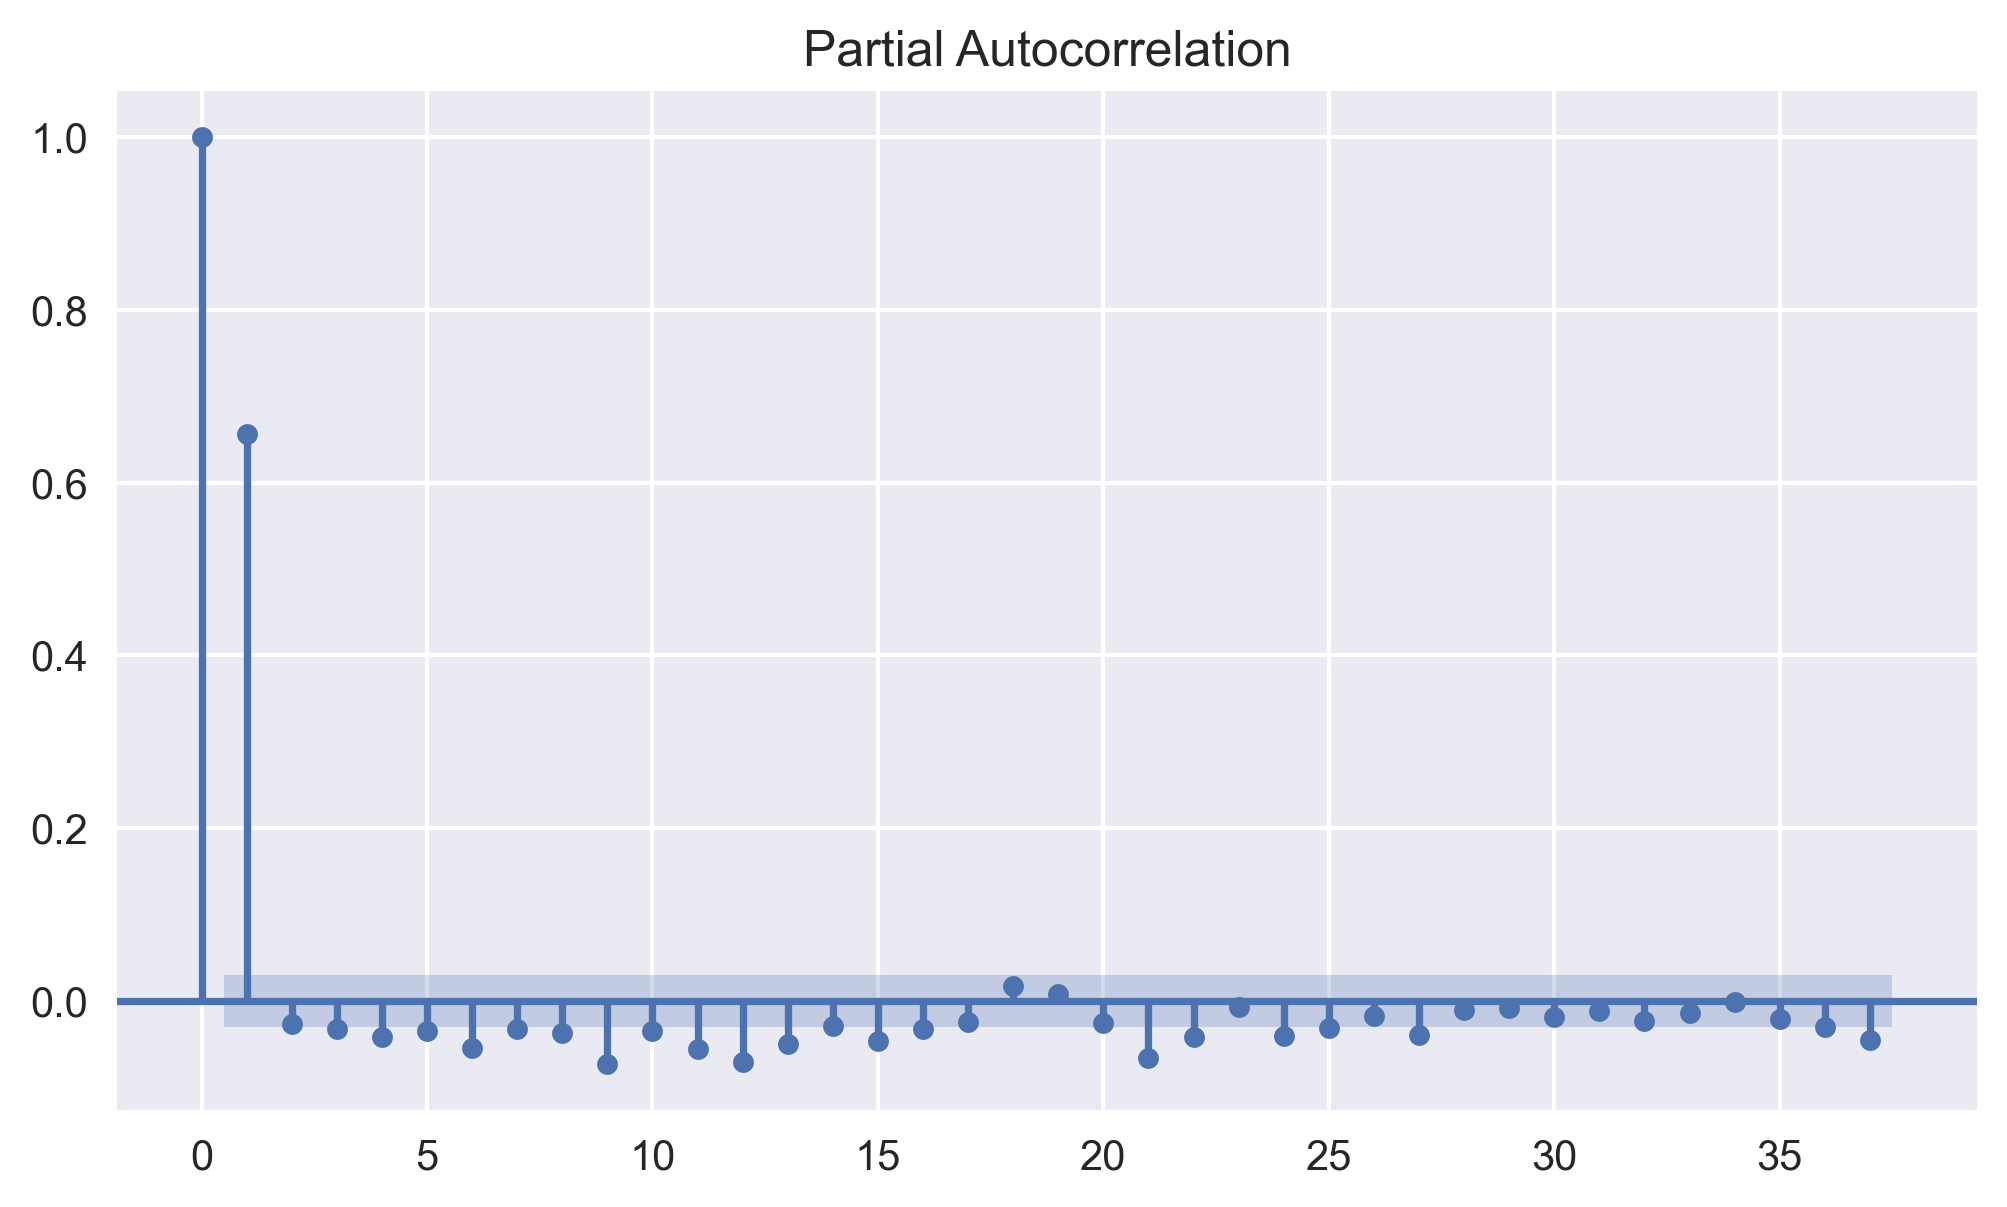

In [228]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1 = train_df.diff(periods=1).iloc[1:]       # 1로 차분
diff_1.plot()
plt.xticks(rotation =90)
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

# MA모델이 적합하다. 
# = 자기상관성(과거로 예측)으로 분석하면 안된다.
# = 이동평균으로 분석해야한다.

In [229]:
# AR(p) : 1~4
# MA(q) : 1

model = ARIMA(train_df, order=(1,1,1))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.STDEV   No. Observations:                 4198
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5642.341
Method:                       css-mle   S.D. of innovations              0.063
Date:                Mon, 15 Nov 2021   AIC                         -11276.683
Time:                        19:13:53   BIC                         -11251.313
Sample:                             1   HQIC                        -11267.712
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.003      0.074      0.941      -0.005       0.006
ar.L1.D.STDEV     0.6357      0.018     35.887      0.000       0.601       0.670
ma.L1.D.STDEV     0.0365      0.023     

In [232]:
model_arima= auto_arima(train_df,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=4,max_q=4,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(train_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8911.136, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10602.775, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11058.585, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-11213.683, Time=1.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-11257.967, Time=1.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11276.045, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11276.681, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11277.896, Time=1.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11280.039, Time=2.26 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-11279.468, Time=4.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11276.933, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11273.341, Time=1.75 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11305.379, Time=3.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11426.642, Time=3.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-11279.

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
afasfadfadfadf

In [233]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(train_df, order = (3,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True, shuffle=False)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.STDEV   No. Observations:                 4198
Model:                 ARIMA(3, 1, 2)   Log Likelihood                5730.480
Method:                       css-mle   S.D. of innovations              0.062
Date:                Mon, 15 Nov 2021   AIC                         -11446.961
Time:                        19:15:29   BIC                         -11402.564
Sample:                             1   HQIC                        -11431.262
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      0.573      0.567      -0.001       0.001
ar.L1.D.STDEV     2.2525      0.160     14.050      0.000       1.938       2.567
ar.L2.D.STDEV    -1.6652      0.265     

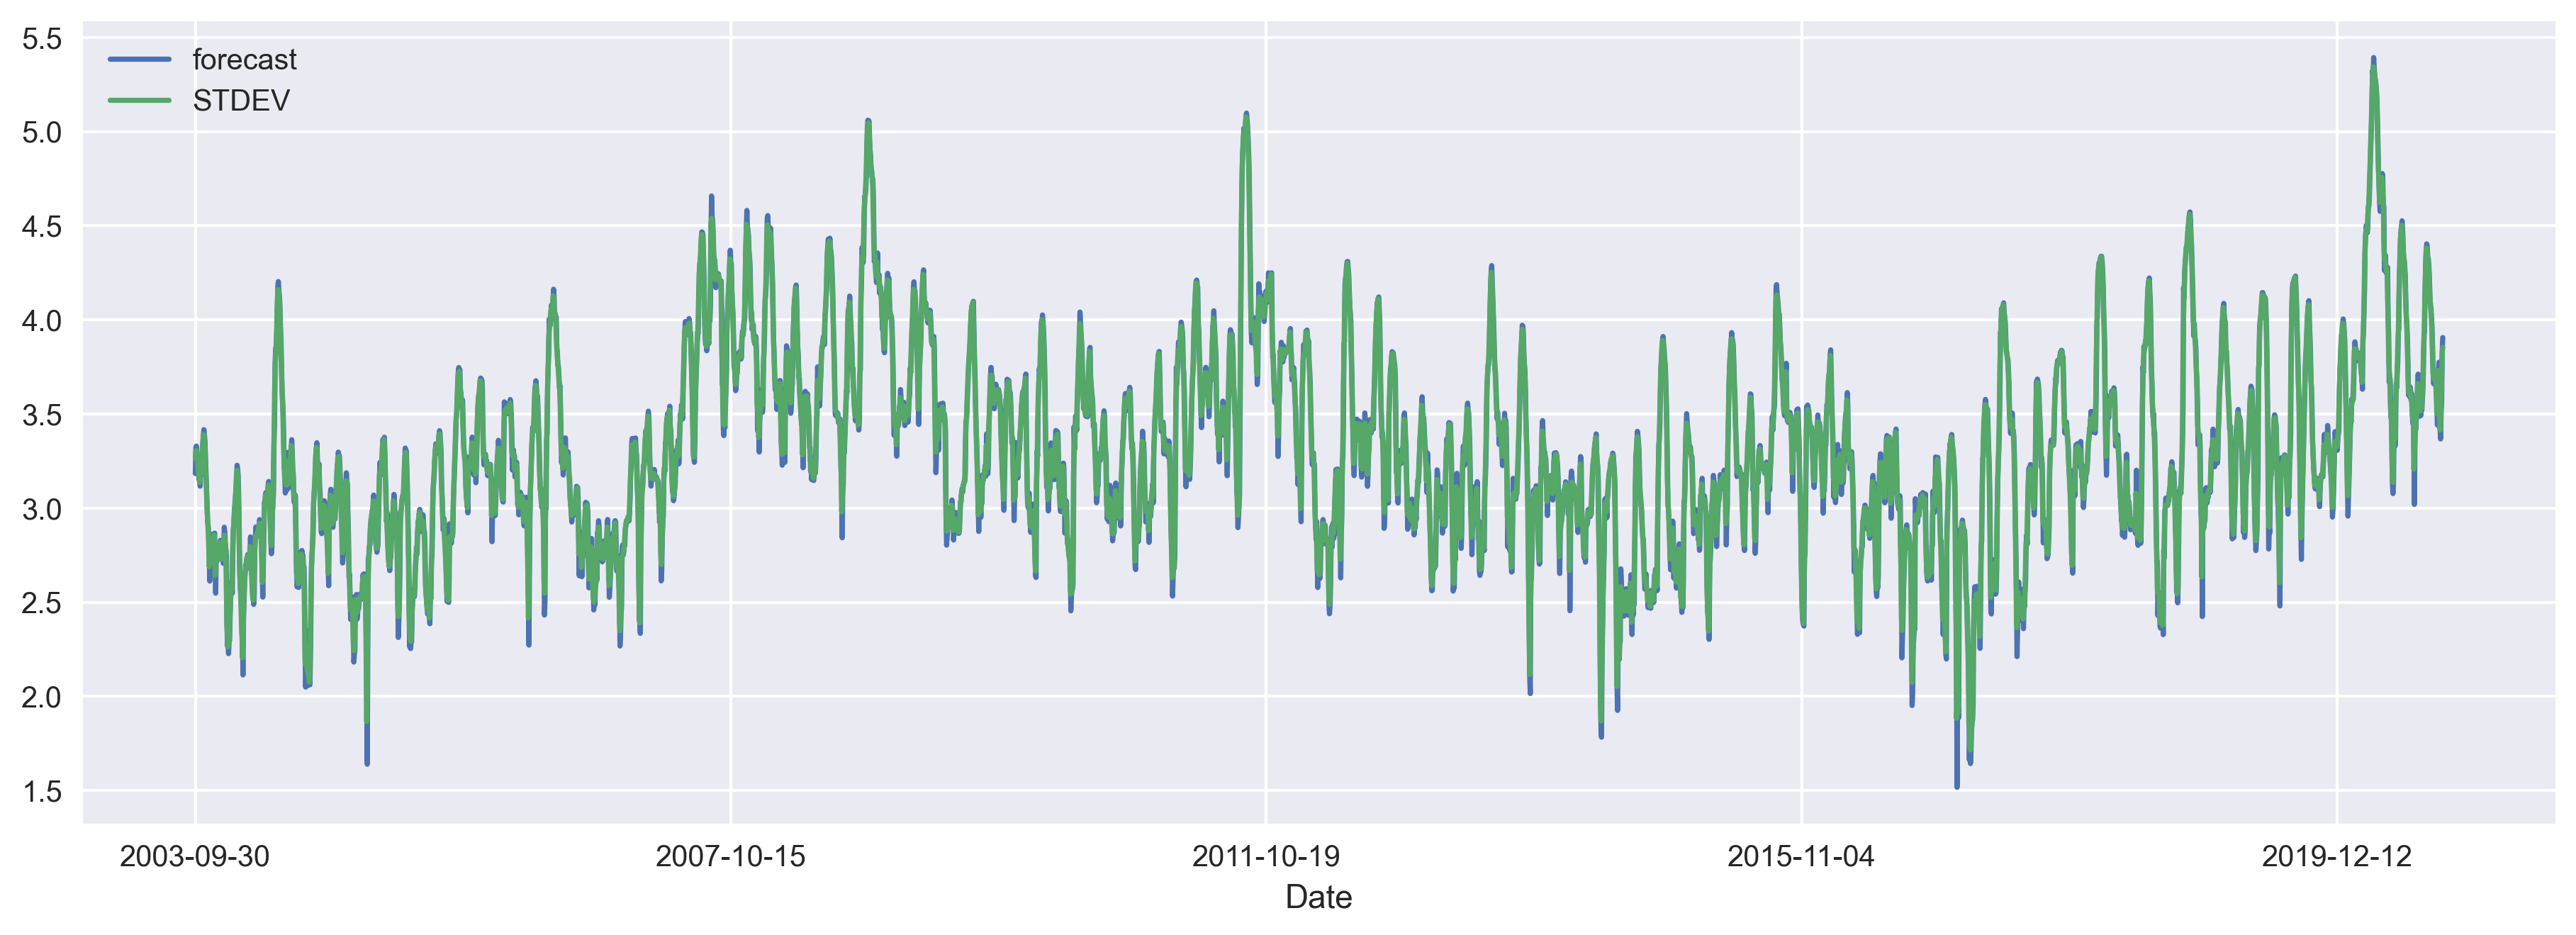

In [234]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

# 1년치(2020-9-29 ~ 2021-9-28) 맞추기

In [235]:
forcast_1 = arima_res.forecast(steps=245) # 1: 다음날 맞춰봐 
#  예측값, stderr,   upper bound~lower bound 
print(forcast_1)
# print(np.array(forcast_1[0])/1000)

(array([3.86684011, 3.87534289, 3.88082275, 3.8843809 , 3.88671741,
       3.88827731, 3.8893435 , 3.89009583, 3.89064865, 3.89107463,
       3.89141998, 3.89171407, 3.89197557, 3.89221636, 3.89244398,
       3.89266323, 3.89287715, 3.8930877 , 3.89329609, 3.89350312,
       3.89370927, 3.89391488, 3.89412013, 3.89432516, 3.89453004,
       3.89473484, 3.89493958, 3.89514428, 3.89534896, 3.89555363,
       3.89575828, 3.89596293, 3.89616758, 3.89637222, 3.89657687,
       3.89678151, 3.89698615, 3.89719079, 3.89739543, 3.89760007,
       3.89780471, 3.89800935, 3.89821399, 3.89841863, 3.89862327,
       3.8988279 , 3.89903254, 3.89923718, 3.89944182, 3.89964646,
       3.8998511 , 3.90005574, 3.90026038, 3.90046502, 3.90066966,
       3.9008743 , 3.90107894, 3.90128358, 3.90148822, 3.90169286,
       3.9018975 , 3.90210214, 3.90230677, 3.90251141, 3.90271605,
       3.90292069, 3.90312533, 3.90332997, 3.90353461, 3.90373925,
       3.90394389, 3.90414853, 3.90435317, 3.90455781, 3.9047

In [236]:
# 로그 다시 원복하기..
forcast_1_sqrt = np.exp(forcast_1[0])
forcast_1_sqrt

array([47.79113251, 48.19922229, 48.46407228, 48.63682223, 48.75059548,
       48.82670056, 48.87878685, 48.91557401, 48.94262285, 48.96347586,
       48.98038822, 48.99479496, 49.00760896, 49.01941087, 49.03056994,
       49.04132099, 49.05181335, 49.06214197, 49.07236723, 49.0825275 ,
       49.09264721, 49.10274188, 49.11282137, 49.12289196, 49.13295764,
       49.14302094, 49.15308349, 49.16314631, 49.17321004, 49.18327512,
       49.19334179, 49.20341023, 49.21348054, 49.22355279, 49.23362703,
       49.24370329, 49.25378158, 49.26386191, 49.27394429, 49.28402872,
       49.29411522, 49.30420378, 49.31429439, 49.32438708, 49.33448183,
       49.34457864, 49.35467752, 49.36477846, 49.37488148, 49.38498656,
       49.39509371, 49.40520293, 49.41531421, 49.42542757, 49.43554299,
       49.44566049, 49.45578005, 49.46590169, 49.4760254 , 49.48615118,
       49.49627904, 49.50640896, 49.51654096, 49.52667503, 49.53681118,
       49.5469494 , 49.5570897 , 49.56723207, 49.57737652, 49.58

In [237]:
real = np.array(np.exp(test_df['STDEV']))

# RMSE 확인

In [238]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(real, forcast_1_sqrt))

28.5711859133949